# Analysis of Study Data - 20251106_141123

Filtered to specific prolific participants with duplicate handling.


In [1]:
# Install required packages (uncomment and run if needed)
# !pip install pandas matplotlib seaborn

# Note: json and collections are built-in Python modules and don't need installation


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Data Loading and Filtering


In [3]:
# Target prolific PIDs to filter
target_prolific_pids = [
    '67477ac7090d737ae33348ea',
    '66f6dfde93de2c0d7eaf463f',
    '5eb339ee6290bc124b8549a6',
    '67ea38f2f2477e3cbdb8202a',  # Appears multiple times (different sessions)
    '675b37b0100714ba57d0fa21',
    '60955a048531613c66404fb2',
    '55c0ca6cfdf99b2e8efc9f4b',
    '67044749c28abfd636ceedf0',
    '6101ca2b4ef4ff44381fe3cd',
    '677d6546138c74881d9f6efc',
]

print(f"Target prolific PIDs: {len(target_prolific_pids)} unique PIDs")
print(f"PIDs (including duplicates): {target_prolific_pids}")


Target prolific PIDs: 10 unique PIDs
PIDs (including duplicates): ['67477ac7090d737ae33348ea', '66f6dfde93de2c0d7eaf463f', '5eb339ee6290bc124b8549a6', '67ea38f2f2477e3cbdb8202a', '675b37b0100714ba57d0fa21', '60955a048531613c66404fb2', '55c0ca6cfdf99b2e8efc9f4b', '67044749c28abfd636ceedf0', '6101ca2b4ef4ff44381fe3cd', '677d6546138c74881d9f6efc']


In [4]:
# Load all data files
moderation_df = pd.read_csv('moderation_sessions_export_20251106_141123.csv')
child_profiles_df = pd.read_csv('child_profiles_export_20251106_141123.csv')
exit_quiz_df = pd.read_csv('exit_quiz_responses_export_20251106_141123.csv')
assignment_time_df = pd.read_csv('assignment_time_export_20251106_141123.csv')

print(f"Loaded data:")
print(f"  Moderation sessions: {len(moderation_df)} rows")
print(f"  Child profiles: {len(child_profiles_df)} rows")
print(f"  Exit quiz responses: {len(exit_quiz_df)} rows")
print(f"  Assignment time: {len(assignment_time_df)} rows")


Loaded data:
  Moderation sessions: 316 rows
  Child profiles: 28 rows
  Exit quiz responses: 23 rows
  Assignment time: 997 rows


In [5]:
# Filter all dataframes by target prolific PIDs
# Note: prolific_pid may be NaN or empty, so we need to handle that
moderation_df_filtered = moderation_df[moderation_df['prolific_pid'].isin(target_prolific_pids)].copy()
child_profiles_df_filtered = child_profiles_df[child_profiles_df['prolific_pid'].isin(target_prolific_pids)].copy()
exit_quiz_df_filtered = exit_quiz_df[exit_quiz_df['prolific_pid'].isin(target_prolific_pids)].copy()
assignment_time_df_filtered = assignment_time_df[assignment_time_df['prolific_pid'].isin(target_prolific_pids)].copy()

print(f"\nFiltered data:")
print(f"  Moderation sessions: {len(moderation_df_filtered)} rows")
print(f"  Child profiles: {len(child_profiles_df_filtered)} rows")
print(f"  Exit quiz responses: {len(exit_quiz_df_filtered)} rows")
print(f"  Assignment time: {len(assignment_time_df_filtered)} rows")

# Check for duplicate PIDs - collect unique sessions from ALL data sources
# (session_number is the correct field to identify unique sessions)
# A session is uniquely identified by (prolific_pid, user_id, session_number)
all_sessions_for_count = []

# Collect sessions from all data sources that have session_number
for df_name, df in [
    ('moderation_sessions', moderation_df_filtered),
    ('child_profiles', child_profiles_df_filtered),
    ('assignment_time', assignment_time_df_filtered)
]:
    if 'user_id' in df.columns and 'session_number' in df.columns:
        sessions = df[['prolific_pid', 'user_id', 'session_number']].drop_duplicates()
        all_sessions_for_count.append(sessions)

# Combine and get unique sessions
all_sessions_count_df = pd.concat(all_sessions_for_count, ignore_index=True).drop_duplicates()

print(f"\nUnique prolific PIDs in filtered data: {moderation_df_filtered['prolific_pid'].nunique()}")
print(f"\nProlific PID distribution (using session_number from ALL data sources):")
pid_counts = all_sessions_count_df.groupby('prolific_pid').agg({
    'user_id': 'nunique',
    'session_number': 'nunique'
}).reset_index()
pid_counts.columns = ['prolific_pid', 'unique_user_ids', 'unique_sessions']
print(pid_counts.sort_values('prolific_pid'))



Filtered data:
  Moderation sessions: 174 rows
  Child profiles: 12 rows
  Exit quiz responses: 13 rows
  Assignment time: 767 rows

Unique prolific PIDs in filtered data: 10

Prolific PID distribution (using session_number from ALL data sources):
               prolific_pid  unique_user_ids  unique_sessions
0  55c0ca6cfdf99b2e8efc9f4b                1                1
1  5eb339ee6290bc124b8549a6                1                1
2  60955a048531613c66404fb2                1                1
3  6101ca2b4ef4ff44381fe3cd                1                1
4  66f6dfde93de2c0d7eaf463f                1                1
5  67044749c28abfd636ceedf0                1                1
6  67477ac7090d737ae33348ea                1                1
7  675b37b0100714ba57d0fa21                1                1
8  677d6546138c74881d9f6efc                1                1
9  67ea38f2f2477e3cbdb8202a                1                2


In [6]:
# Create a unique session identifier: prolific_pid + user_id + session_number
# This helps identify separate sessions for the same prolific_pid
moderation_df_filtered['session_id'] = (
    moderation_df_filtered['prolific_pid'].astype(str) + '_' + 
    moderation_df_filtered['user_id'].astype(str) + '_' + 
    moderation_df_filtered['session_number'].astype(str)
)

# To get accurate session counts, we need to check ALL data sources, not just moderation_sessions
# A session might exist in child_profiles, exit_quiz, or assignment_time even without moderation data
all_sessions = []

# Collect sessions from all data sources
for df_name, df in [
    ('moderation_sessions', moderation_df_filtered),
    ('child_profiles', child_profiles_df_filtered),
    ('exit_quiz', exit_quiz_df_filtered),
    ('assignment_time', assignment_time_df_filtered)
]:
    if 'user_id' in df.columns and 'session_number' in df.columns:
        sessions = df[['prolific_pid', 'user_id', 'session_number']].drop_duplicates()
        all_sessions.append(sessions)

# Combine all sessions and get unique combinations
all_sessions_df = pd.concat(all_sessions, ignore_index=True).drop_duplicates()
all_sessions_df['session_id'] = (
    all_sessions_df['prolific_pid'].astype(str) + '_' + 
    all_sessions_df['user_id'].astype(str) + '_' + 
    all_sessions_df['session_number'].astype(str)
)

print(f"Unique sessions across all data sources (prolific_pid + user_id + session_number): {all_sessions_df['session_id'].nunique()}")
print(f"\nSession breakdown by prolific_pid (using all data sources):")
session_breakdown = all_sessions_df.groupby('prolific_pid').agg({
    'session_id': 'nunique',
    'user_id': 'nunique',
    'session_number': lambda x: sorted(x.unique().tolist())
}).reset_index()
session_breakdown.columns = ['prolific_pid', 'unique_sessions', 'unique_users', 'session_numbers']
print(session_breakdown.sort_values('prolific_pid'))


Unique sessions across all data sources (prolific_pid + user_id + session_number): 11

Session breakdown by prolific_pid (using all data sources):
               prolific_pid  unique_sessions  unique_users session_numbers
0  55c0ca6cfdf99b2e8efc9f4b                1             1             [1]
1  5eb339ee6290bc124b8549a6                1             1             [1]
2  60955a048531613c66404fb2                1             1             [1]
3  6101ca2b4ef4ff44381fe3cd                1             1             [1]
4  66f6dfde93de2c0d7eaf463f                1             1             [1]
5  67044749c28abfd636ceedf0                1             1             [1]
6  67477ac7090d737ae33348ea                1             1             [1]
7  675b37b0100714ba57d0fa21                1             1             [1]
8  677d6546138c74881d9f6efc                1             1             [1]
9  67ea38f2f2477e3cbdb8202a                2             1          [1, 3]


In [7]:
# Parse the strategies column (it contains JSON arrays)
def parse_strategies(strategies_str):
    """Parse strategies string into a list"""
    try:
        if pd.isna(strategies_str) or strategies_str == '':
            return []
        return json.loads(strategies_str)
    except:
        return []

# Use filtered dataframe for analysis
df = moderation_df_filtered.copy()
df['strategies_parsed'] = df['strategies'].apply(parse_strategies)

print(f"Total filtered records: {len(df)}")
print(f"\nFirst few rows of strategies column:")
print(df['strategies'].head(10))


Total filtered records: 174

First few rows of strategies column:
43                                 []
44                                 []
45               ["Defer to Parents"]
46                                 []
47                                 []
48                                 []
49                                 []
50                                 []
51                                 []
52    ["Emphasize Emotional Support"]
Name: strategies, dtype: object


## 0. Time Spent Analysis


In [8]:
# Analyze assignment time data per prolific PID
# Convert milliseconds to minutes for readability
assignment_time_df_filtered['cumulative_minutes'] = assignment_time_df_filtered['cumulative_ms'] / 60000
assignment_time_df_filtered['delta_minutes'] = assignment_time_df_filtered['active_ms_delta'] / 60000

# Get the maximum cumulative time per prolific_pid, user_id, session_number (final time spent)
time_per_session = assignment_time_df_filtered.groupby(['prolific_pid', 'user_id', 'session_number'])['cumulative_ms'].max().reset_index()
time_per_session['total_minutes'] = time_per_session['cumulative_ms'] / 60000
time_per_session = time_per_session.sort_values(['prolific_pid', 'user_id', 'session_number'])

print("=== Time Spent per Participant-Session Pair ===")
print(f"\nTotal sessions: {len(time_per_session)}")
print(f"\nTime per session (for compensation):")
print(time_per_session[['prolific_pid', 'user_id', 'session_number', 'total_minutes']].to_string(index=False))

# Aggregate by prolific_pid - first collect session numbers, then aggregate totals
session_numbers_per_pid = time_per_session.groupby('prolific_pid')['session_number'].apply(lambda x: sorted(x.unique().tolist())).reset_index()
session_numbers_per_pid.columns = ['prolific_pid', 'unique_session_numbers']

# Aggregate time statistics
time_stats = time_per_session.groupby('prolific_pid')['total_minutes'].agg(['sum', 'mean', 'median']).reset_index()
time_stats.columns = ['prolific_pid', 'total_minutes', 'avg_minutes_per_session', 'median_minutes_per_session']

# Merge
time_by_pid_agg = session_numbers_per_pid.merge(time_stats, on='prolific_pid')
time_by_pid_agg['num_sessions'] = time_by_pid_agg['unique_session_numbers'].apply(len)
time_by_pid_agg = time_by_pid_agg.sort_values('total_minutes', ascending=False)

print("\n" + "="*70)
print("=== Time Spent per Prolific PID (Aggregated) ===")
print(f"\nTotal participants: {time_by_pid_agg['prolific_pid'].nunique()}")
print(f"\nTime spent summary:")
print(time_by_pid_agg[['prolific_pid', 'total_minutes', 'avg_minutes_per_session', 'median_minutes_per_session', 'num_sessions', 'unique_session_numbers']].to_string(index=False))

print(f"\nOverall statistics:")
print(f"  Total time across all participants: {time_by_pid_agg['total_minutes'].sum():.2f} minutes ({time_by_pid_agg['total_minutes'].sum()/60:.2f} hours)")
print(f"  Mean time per participant: {time_by_pid_agg['total_minutes'].mean():.2f} minutes")
print(f"  Median time per participant: {time_by_pid_agg['total_minutes'].median():.2f} minutes")
print(f"  Min time: {time_by_pid_agg['total_minutes'].min():.2f} minutes")
print(f"  Max time: {time_by_pid_agg['total_minutes'].max():.2f} minutes")


=== Time Spent per Participant-Session Pair ===

Total sessions: 11

Time per session (for compensation):
            prolific_pid                              user_id  session_number  total_minutes
55c0ca6cfdf99b2e8efc9f4b b535ced6-55fc-401f-8e28-e51815063790               1      18.466667
5eb339ee6290bc124b8549a6 7255769d-ab16-4307-97b6-cf36210c0c23               1      31.266667
60955a048531613c66404fb2 ed19a99e-2992-4747-ae62-51220b6c7ec0               1      26.933333
6101ca2b4ef4ff44381fe3cd 8c035500-8ba3-4021-96c0-21c357309a42               1      19.000000
66f6dfde93de2c0d7eaf463f 47344ab8-2ad1-4a78-a6d3-ada2fec23070               1      36.500000
67044749c28abfd636ceedf0 fb80156e-c1f5-48c3-ab63-a216956d5a5e               1      51.450000
67477ac7090d737ae33348ea 6a7879f8-3887-45de-a3a4-92db4f33ff74               1      25.183333
675b37b0100714ba57d0fa21 e4c95027-224e-4fbb-b728-863c3c1a08f7               1      18.066667
677d6546138c74881d9f6efc fb6bd640-a956-41bc-846d-782a5d5a

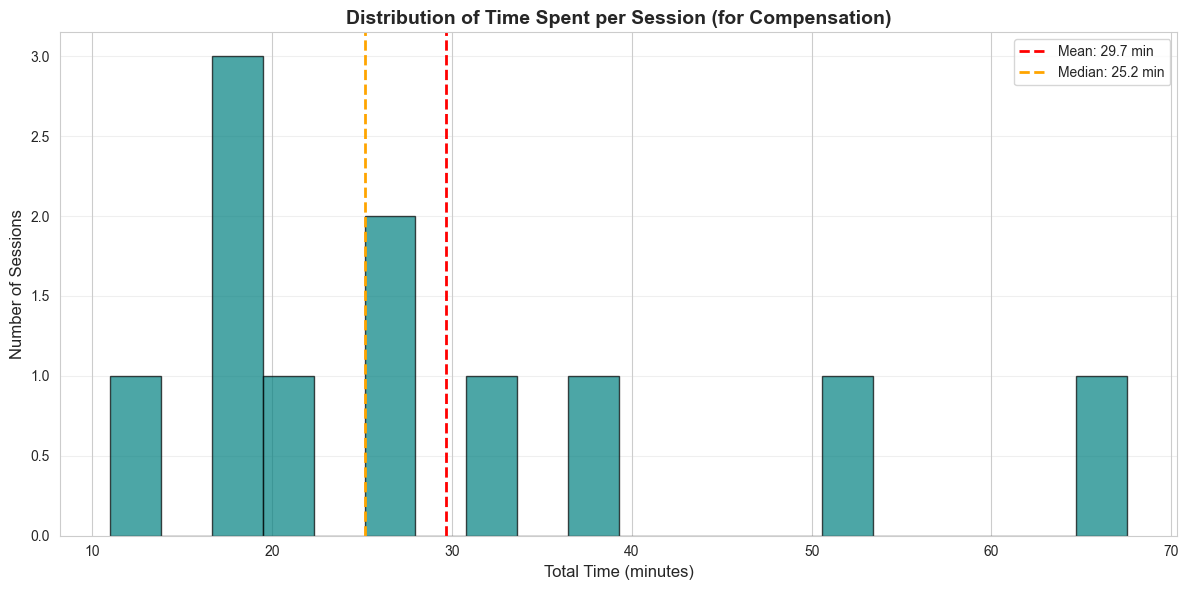


Time per session statistics (for compensation calculation):
count    11.000000
mean     29.654545
std      16.686836
min      11.000000
25%      18.733333
50%      25.183333
75%      33.883333
max      67.516667
Name: total_minutes, dtype: float64

Total number of sessions to compensate: 11


In [9]:
# Plot distribution of time spent per session
# Note: This shows the distribution of time per session pair (prolific_pid, user_id, session_number)
# Each session is compensated independently based on its total_minutes value
if len(time_per_session) > 0:
    plt.figure(figsize=(12, 6))
    plt.hist(time_per_session['total_minutes'], bins=20, color='teal', edgecolor='black', alpha=0.7)
    plt.xlabel('Total Time (minutes)', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)
    plt.title('Distribution of Time Spent per Session (for Compensation)', fontsize=14, fontweight='bold')
    plt.axvline(time_per_session['total_minutes'].mean(), color='red', linestyle='--', 
                label=f"Mean: {time_per_session['total_minutes'].mean():.1f} min", linewidth=2)
    plt.axvline(time_per_session['total_minutes'].median(), color='orange', linestyle='--', 
                label=f"Median: {time_per_session['total_minutes'].median():.1f} min", linewidth=2)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTime per session statistics (for compensation calculation):")
    stats = time_per_session['total_minutes'].describe()
    print(stats)
    print(f"\nTotal number of sessions to compensate: {len(time_per_session)}")
else:
    print("No time data available.")


### Compensation

Pay to the 75th percentile - 34 minutes @ $16/hr = 9.06. Upping to 10 because was wrong of us to quote the wrong time without testing.

Will still provide bonus.

Hello, 

We want to sincerely apologize for publishing this task that took significantly longer than the quoted time. We will compensate each participant with $10 ($6 in bonus pay, in addition to the $4 quoted in the original prolific assignment). This will cover the 75th percentile of additional time each participant spent at the $16/hr quoted rate. 

We will still distribute other bonus payments as described in the survey description. Again, we're so sorry for misjudging the time required and for disrespecting your time. We will test with participants internally before launching in the future. Thank you to those who reached out to us about this issue. 

Sincerely, Data Smith Lab at UC San Diego

## 1. Individual Strategy Counts


In [10]:
# Count individual strategies
all_strategies = []
for strategies_list in df['strategies_parsed']:
    all_strategies.extend(strategies_list)

strategy_counts = Counter(all_strategies)

# Convert to DataFrame for easier plotting
individual_df = pd.DataFrame([
    {'Strategy': strategy, 'Count': count}
    for strategy, count in strategy_counts.most_common()
])

print(f"\nTotal unique strategies: {len(individual_df)}")
print(f"Total strategy uses: {individual_df['Count'].sum()}")
print("\nStrategy counts:")
print(individual_df)



Total unique strategies: 10
Total strategy uses: 53

Strategy counts:
                      Strategy  Count
0  Emphasize Emotional Support     12
1          Tailor to Age Group     11
2             Defer to Parents      9
3       Clarify Child's Intent      7
4           Defer to Resources      6
5       Remove Harmful Phrases      3
6      Encourage Introspection      2
7  Omit Unprompted Suggestions      1
8     Emphasize Risk Awareness      1
9  Refuse Response and Explain      1


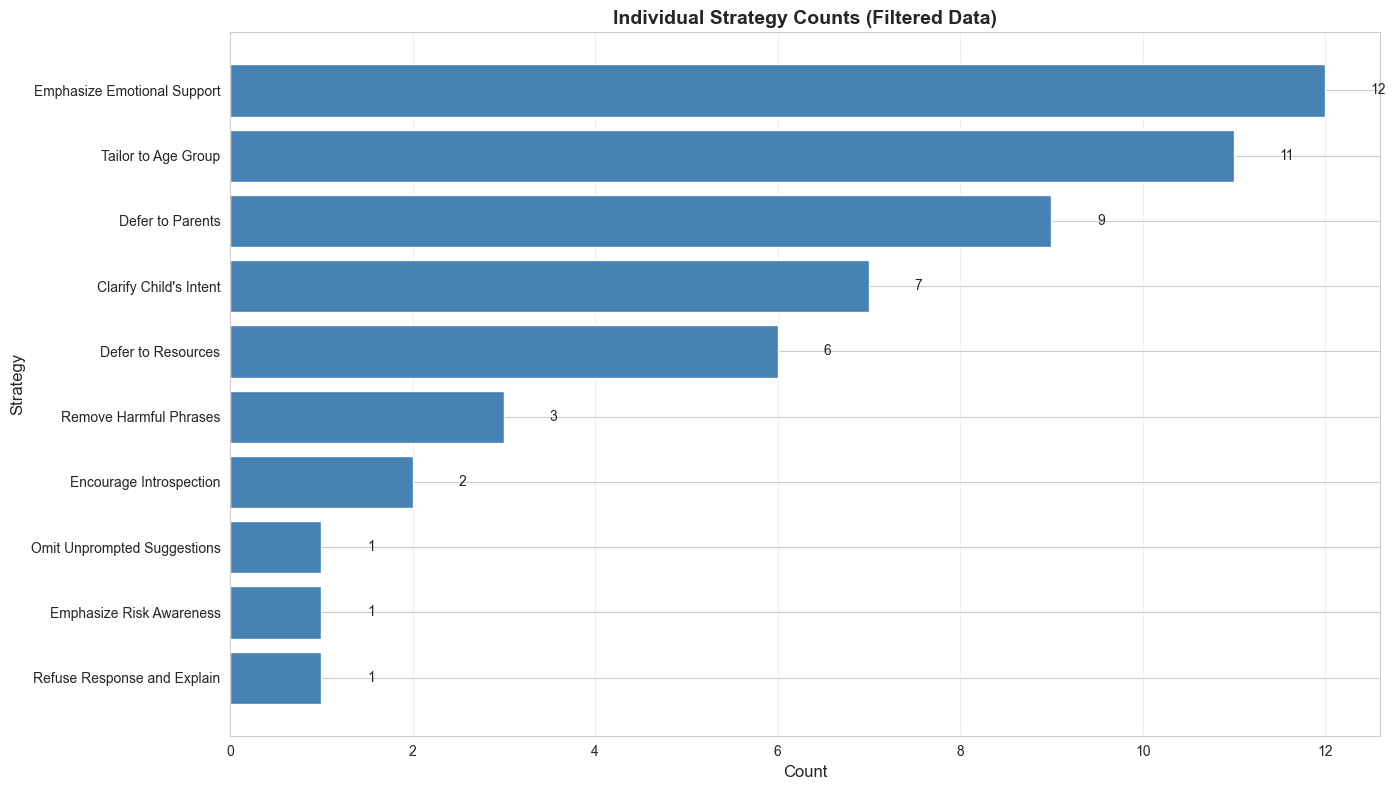

In [11]:
# Plot individual strategy counts
if len(individual_df) > 0:
    plt.figure(figsize=(14, 8))
    plt.barh(individual_df['Strategy'], individual_df['Count'], color='steelblue')
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Strategy', fontsize=12)
    plt.title('Individual Strategy Counts (Filtered Data)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Highest count at top
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3)

    # Add count labels on bars
    for i, (strategy, count) in enumerate(zip(individual_df['Strategy'], individual_df['Count'])):
        plt.text(count + 0.5, i, str(count), va='center', fontsize=10)

    plt.show()
else:
    print("No strategies found in filtered data.")


## 2. Strategy Combinations (Order-Independent)


In [16]:
# Count strategy combinations (order doesn't matter, so we'll use frozenset)
def strategies_to_combination(strategies_list):
    """Convert list to frozenset for order-independent comparison"""
    if not strategies_list:
        return frozenset(['[No strategies]'])
    return frozenset(strategies_list)

df['strategy_combination'] = df['strategies_parsed'].apply(strategies_to_combination)

combination_counts = Counter(df['strategy_combination'])

# Convert combinations to readable strings for plotting
combination_data = []
for combo, count in combination_counts.most_common():
    if combo == frozenset(['[No strategies]']):
        continue #skip no strategies
    else:
        combo_str = ' + '.join(sorted(combo))
    combination_data.append({'Combination': combo_str, 'Count': count, 'Num_Strategies': len(combo)})

combinations_df = pd.DataFrame(combination_data)

print(f"\nTotal unique combinations: {len(combinations_df)}")
print(f"\nTop 20 combinations:")
print(combinations_df.head(20))



Total unique combinations: 20

Top 20 combinations:
                                          Combination  Count  Num_Strategies
0                                 Tailor to Age Group      9               1
1                         Emphasize Emotional Support      3               1
2                                    Defer to Parents      2               1
3   Clarify Child's Intent + Emphasize Emotional S...      2               2
4   Emphasize Emotional Support + Omit Unprompted ...      1               2
5   Defer to Parents + Defer to Resources + Emphas...      1               3
6           Clarify Child's Intent + Defer to Parents      1               2
7          Defer to Parents + Encourage Introspection      1               2
8           Defer to Parents + Remove Harmful Phrases      1               2
9      Defer to Parents + Emphasize Emotional Support      1               2
10   Defer to Resources + Emphasize Emotional Support      1               2
11  Defer to Resources 

In [17]:
# Calculate proportion of scenarios moderated
# A scenario is considered "moderated" if initial_decision == 'moderate'
# (This indicates the user chose to moderate the response)

total_scenarios = len(df)
moderated_scenarios = (df['initial_decision'] == 'moderate').sum()
proportion_moderated = moderated_scenarios / total_scenarios if total_scenarios > 0 else 0

print("=== Moderation Statistics ===")
print(f"Total scenarios: {total_scenarios}")
print(f"Moderated scenarios: {moderated_scenarios}")
print(f"Not moderated (accepted original): {(df['initial_decision'] == 'accept_original').sum()}")
print(f"Other decisions: {(~df['initial_decision'].isin(['moderate', 'accept_original'])).sum()}")
print(f"\nProportion moderated: {proportion_moderated:.2%} ({proportion_moderated:.4f})")

# Create a summary DataFrame for export
moderation_summary = pd.DataFrame({
    'metric': ['total_scenarios', 'moderated_scenarios', 'not_moderated_scenarios', 'proportion_moderated'],
    'value': [
        total_scenarios,
        moderated_scenarios,
        (df['initial_decision'] == 'accept_original').sum(),
        proportion_moderated
    ]
})

# Export to CSV (using timestamp from existing export files)
import os
import glob
csv_files = glob.glob('*_export_*.csv')
if csv_files:
    # Extract timestamp from first export file (format: name_export_YYYYMMDD_HHMMSS.csv)
    filename = csv_files[0]
    parts = filename.split('_export_')
    if len(parts) == 2:
        export_timestamp = parts[1].replace('.csv', '')
    else:
        export_timestamp = "20251106_141123"  # Fallback
else:
    export_timestamp = "20251106_141123"  # Fallback
    
output_file = f'moderation_proportion_export_{export_timestamp}.csv'
moderation_summary.to_csv(output_file, index=False)
print(f"\nExported moderation statistics to: {output_file}")
print(moderation_summary)


=== Moderation Statistics ===
Total scenarios: 174
Moderated scenarios: 49
Not moderated (accepted original): 125
Other decisions: 0

Proportion moderated: 28.16% (0.2816)

Exported moderation statistics to: moderation_proportion_export_20251106_141123.csv
                    metric       value
0          total_scenarios  174.000000
1      moderated_scenarios   49.000000
2  not_moderated_scenarios  125.000000
3     proportion_moderated    0.281609


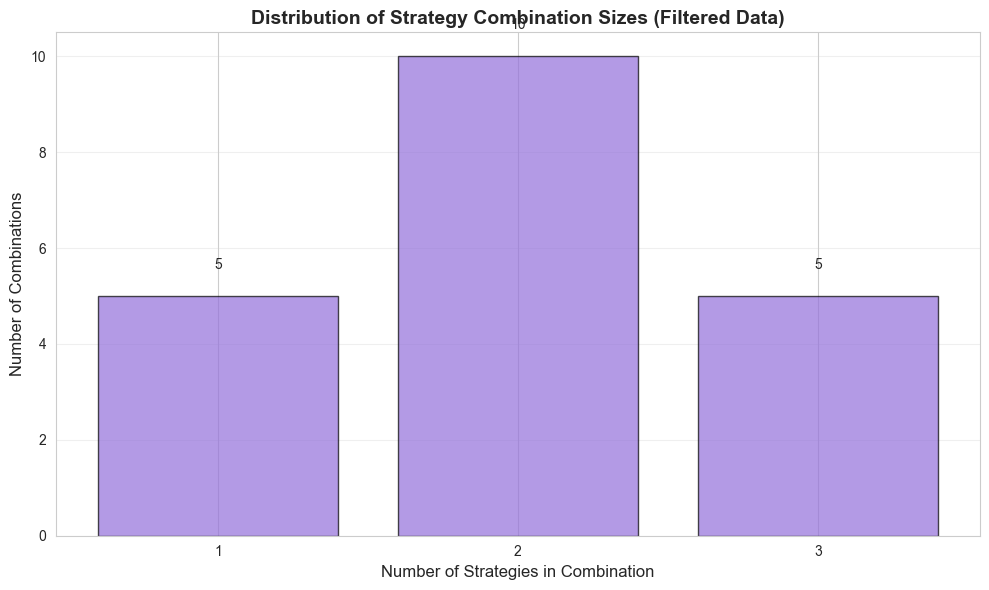


Distribution of number of strategies per combination:
Num_Strategies
1     5
2    10
3     5
Name: count, dtype: int64


In [18]:
# Plot distribution of number of strategies in combinations
if len(combinations_df) > 0:
    plt.figure(figsize=(10, 6))
    num_strategies_dist = combinations_df['Num_Strategies'].value_counts().sort_index()
    plt.bar(num_strategies_dist.index, num_strategies_dist.values, color='mediumpurple', edgecolor='black', alpha=0.7)
    plt.xlabel('Number of Strategies in Combination', fontsize=12)
    plt.ylabel('Number of Combinations', fontsize=12)
    plt.title('Distribution of Strategy Combination Sizes (Filtered Data)', fontsize=14, fontweight='bold')
    plt.xticks(num_strategies_dist.index)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for x, y in zip(num_strategies_dist.index, num_strategies_dist.values):
        plt.text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    print(f"\nDistribution of number of strategies per combination:")
    print(num_strategies_dist)
else:
    print("No strategy combinations found.")


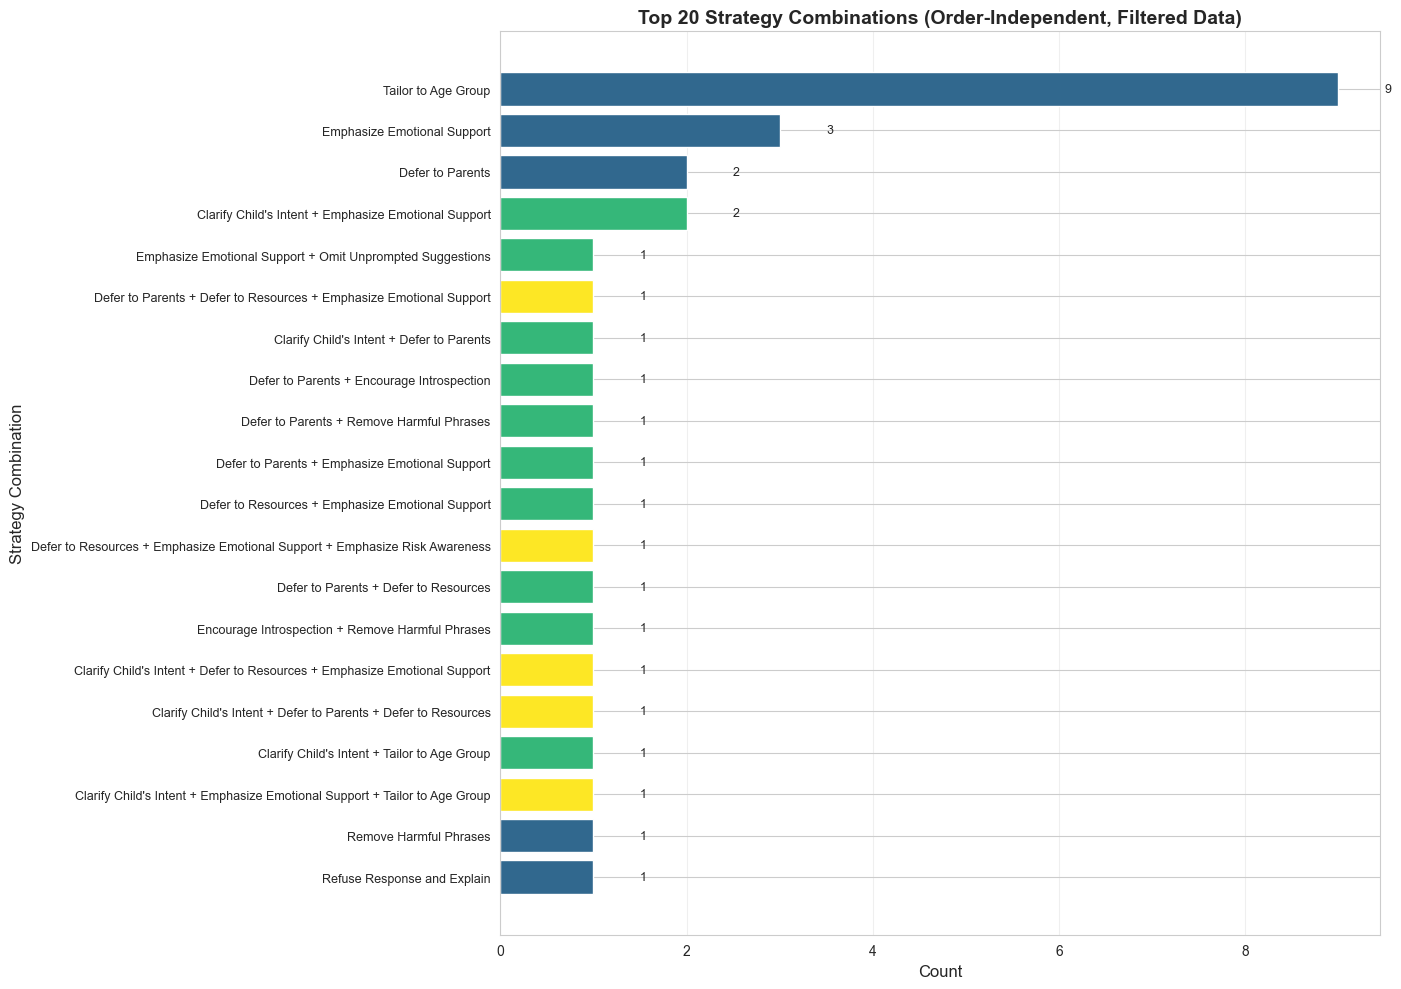

In [19]:
# Plot top 20 strategy combinations
if len(combinations_df) > 0:
    top_n = min(20, len(combinations_df))
    plot_data = combinations_df.head(top_n)

    plt.figure(figsize=(14, 10))
    colors = plt.cm.viridis(plot_data['Num_Strategies'] / plot_data['Num_Strategies'].max())
    plt.barh(range(len(plot_data)), plot_data['Count'], color=colors)
    plt.yticks(range(len(plot_data)), plot_data['Combination'], fontsize=9)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Strategy Combination', fontsize=12)
    plt.title(f'Top {top_n} Strategy Combinations (Order-Independent, Filtered Data)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Highest count at top
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(plot_data['Count']):
        plt.text(count + 0.5, i, str(count), va='center', fontsize=9)

    plt.show()
else:
    print("No strategy combinations to plot.")


## 4. Participant-Level Analysis


In [21]:
# Group by participant (prolific_pid, user_id, session_number) and calculate statistics
participant_stats = df.groupby(['prolific_pid', 'user_id', 'session_number']).agg({
    'id': 'count',  # Number of moderation sessions
    'num_strategies': ['sum', 'mean'],
    'initial_decision': lambda x: x.value_counts().to_dict(),
    'is_final_version': 'sum',
    'child_id': 'nunique',  # Number of unique children
}).reset_index()

participant_stats.columns = ['prolific_pid', 'user_id', 'session_number', 'total_sessions', 
                            'total_strategies', 'avg_strategies', 'decisions', 
                            'final_versions', 'num_children']

# Sort by prolific_pid, then user_id, then session_number
participant_stats = participant_stats.sort_values(['prolific_pid', 'user_id', 'session_number'])

print("Participant Statistics (sorted by prolific_pid, user_id, session_number):")
print(participant_stats.to_string())


Participant Statistics (sorted by prolific_pid, user_id, session_number):
                prolific_pid                               user_id  session_number  total_sessions  total_strategies  avg_strategies                               decisions  final_versions  num_children
0   55c0ca6cfdf99b2e8efc9f4b  b535ced6-55fc-401f-8e28-e51815063790               1              12                 7        0.583333   {'accept_original': 9, 'moderate': 3}              12             1
1   5eb339ee6290bc124b8549a6  7255769d-ab16-4307-97b6-cf36210c0c23               1              15                 6        0.400000  {'accept_original': 11, 'moderate': 4}              12             1
2   60955a048531613c66404fb2  ed19a99e-2992-4747-ae62-51220b6c7ec0               1              12                14        1.166667   {'moderate': 7, 'accept_original': 5}              12             1
3   6101ca2b4ef4ff44381fe3cd  8c035500-8ba3-4021-96c0-21c357309a42               1              13                

In [22]:
# Summary by prolific_pid (aggregating across all sessions for each PID)
pid_summary = df.groupby('prolific_pid').agg({
    'user_id': 'nunique',
    'session_number': 'nunique',
    'session_id': 'nunique',
    'id': 'count',
    'num_strategies': ['sum', 'mean'],
    'is_final_version': 'sum',
}).reset_index()

pid_summary.columns = ['prolific_pid', 'unique_users', 'unique_sessions', 'unique_session_ids', 
                       'total_moderation_sessions', 'total_strategies', 'avg_strategies', 'final_versions']

pid_summary = pid_summary.sort_values('prolific_pid')

print("\nSummary by Prolific PID (aggregated across all sessions):")
print(pid_summary.to_string())



Summary by Prolific PID (aggregated across all sessions):
               prolific_pid  unique_users  unique_sessions  unique_session_ids  total_moderation_sessions  total_strategies  avg_strategies  final_versions
0  55c0ca6cfdf99b2e8efc9f4b             1                1                   1                         12                 7        0.583333              12
1  5eb339ee6290bc124b8549a6             1                1                   1                         15                 6        0.400000              12
2  60955a048531613c66404fb2             1                1                   1                         12                14        1.166667              12
3  6101ca2b4ef4ff44381fe3cd             1                1                   1                         13                10        0.769231              12
4  66f6dfde93de2c0d7eaf463f             1                1                   1                         15                 3        0.200000              12
5  67

Upon manual inspection, comparing responses to moderation activity, participants with avg_strategies <.1 for sure did not engage enough for bonus b/c had concerns and chose not to moderate anyways.

Inspected .1-.3 manually, and they seemed to engage enough to receive bonus.

In [23]:
# Calculate range of reflection lengths per participant-session
# Extract reflection from session_metadata JSON and calculate character length

def extract_reflection_length(metadata_str):
    """Extract reflection from session_metadata JSON and return its length"""
    if pd.isna(metadata_str) or not metadata_str or metadata_str == '':
        return None
    try:
        metadata = json.loads(metadata_str)
        reflection = metadata.get('reflection', '')
        if reflection:
            return len(str(reflection))
        return None
    except (json.JSONDecodeError, TypeError):
        return None

# Apply function to extract reflection lengths
moderation_df_filtered['reflection_length'] = moderation_df_filtered['session_metadata'].apply(extract_reflection_length)

# Filter out rows with no reflection
reflection_data = moderation_df_filtered[moderation_df_filtered['reflection_length'].notna()].copy()

if len(reflection_data) > 0:
    # Group by participant-session and calculate range (min, max) of reflection lengths
    reflection_ranges = reflection_data.groupby(['prolific_pid', 'user_id', 'session_number'])['reflection_length'].agg([
        ('min_length', 'min'),
        ('max_length', 'max'),
        ('mean_length', 'mean'),
        ('count', 'count')
    ]).reset_index()
    
    reflection_ranges = reflection_ranges.sort_values(['prolific_pid', 'user_id', 'session_number'])
    reflection_ranges['range'] = reflection_ranges['max_length'] - reflection_ranges['min_length']
    
    print("=== Range of Reflection Lengths per Participant-Session ===")
    print(f"\nTotal participant-session pairs with reflections: {len(reflection_ranges)}")
    print(f"Total scenarios with reflections: {len(reflection_data)}")
    print(f"\nReflection length ranges (in characters):")
    print(reflection_ranges[['prolific_pid', 'user_id', 'session_number', 'count', 'min_length', 'max_length', 'range', 'mean_length']].to_string(index=False))
    
    print(f"\nOverall statistics across all reflections:")
    print(f"  Min reflection length: {reflection_data['reflection_length'].min()} characters")
    print(f"  Max reflection length: {reflection_data['reflection_length'].max()} characters")
    print(f"  Mean reflection length: {reflection_data['reflection_length'].mean():.1f} characters")
    print(f"  Median reflection length: {reflection_data['reflection_length'].median():.1f} characters")
    print(f"  Total scenarios with reflections: {len(reflection_data)}")
    print(f"  Total scenarios without reflections: {len(moderation_df_filtered) - len(reflection_data)}")
else:
    print("No reflection data found in session_metadata.")


=== Range of Reflection Lengths per Participant-Session ===

Total participant-session pairs with reflections: 11
Total scenarios with reflections: 174

Reflection length ranges (in characters):
            prolific_pid                              user_id  session_number  count  min_length  max_length  range  mean_length
55c0ca6cfdf99b2e8efc9f4b b535ced6-55fc-401f-8e28-e51815063790               1     12          94         218    124   156.833333
5eb339ee6290bc124b8549a6 7255769d-ab16-4307-97b6-cf36210c0c23               1     15          27         189    162   114.733333
60955a048531613c66404fb2 ed19a99e-2992-4747-ae62-51220b6c7ec0               1     12         112         309    197   201.500000
6101ca2b4ef4ff44381fe3cd 8c035500-8ba3-4021-96c0-21c357309a42               1     13          84         236    152   149.307692
66f6dfde93de2c0d7eaf463f 47344ab8-2ad1-4a78-a6d3-ada2fec23070               1     15          37         253    216   153.600000
67044749c28abfd636ceedf0 fb8015

Upon manual inspection, mean_length of ~10 is way too low to receive bonus.

Participants in the double digit range will receive bonus upon manual inspection.

## Payments Google Sheet:

https://docs.google.com/spreadsheets/d/1g4VZSSb5O_phiDHQ9Wccg9a-bG3Ln_0o_Cxq_tG6ANI/edit?gid=0#gid=0